# IMDB Scraper
Reference：https://python.plainenglish.io/how-to-scrape-imdb-data-9d7535b98576|
## Data source https://www.imdb.com
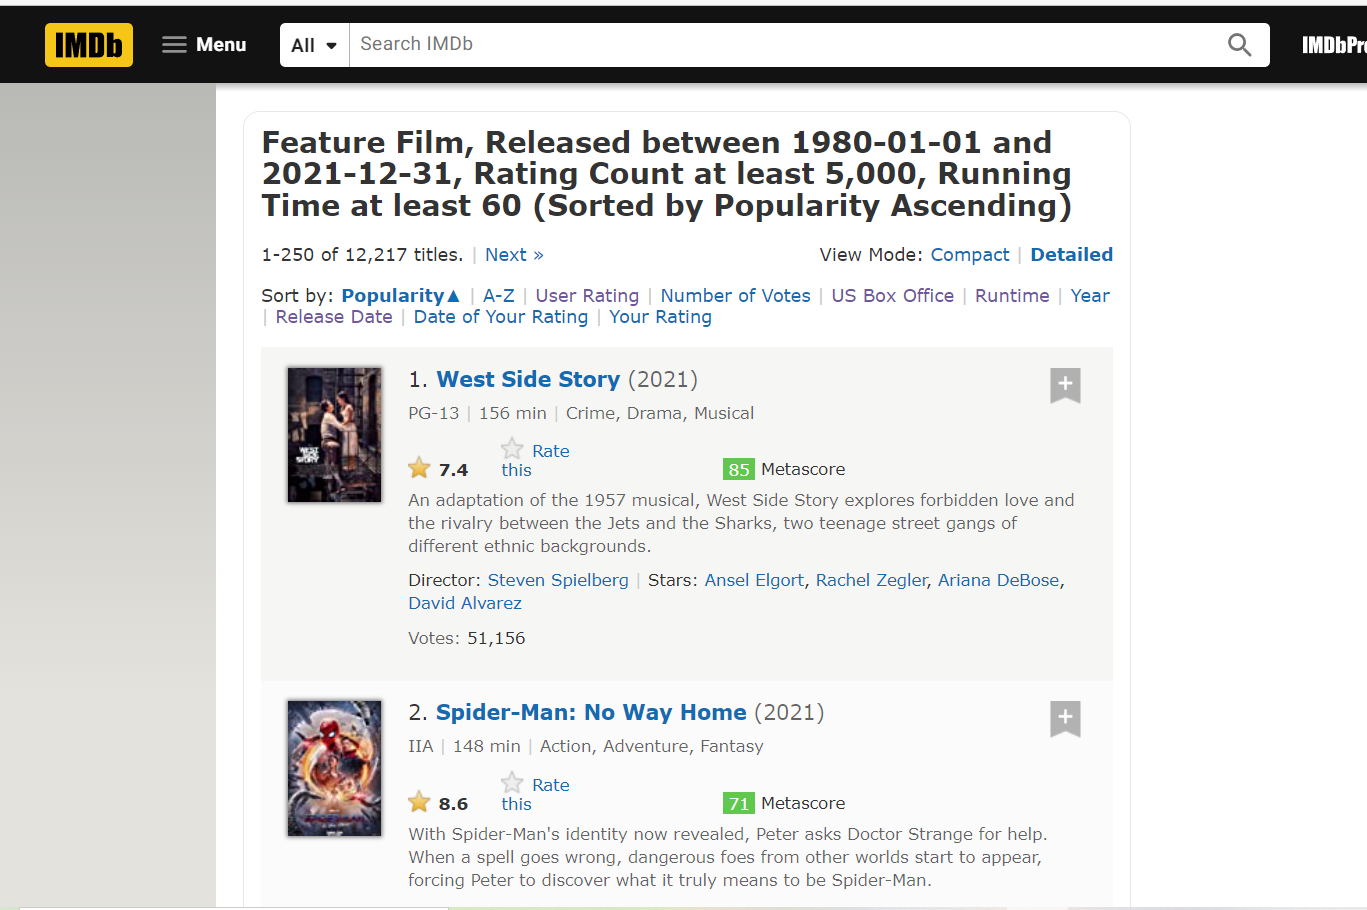



### 引入所需库
* [parse](https://pypi.org/project/parse/)
* [requests](https://docs.python-requests.org/en/latest/)
* [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)
* [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc.zh/)
* [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html)


In [1]:
from dateutil.parser import parse
import requests
import pandas as pd
from bs4 import BeautifulSoup
import concurrent.futures

### 我们准备分析的数据有：
1. 电影标题（Movie title）
2. 上映年份（Released Year）
3. 分级（Certification)
4. 时长（Runtime)
5. 评分（Rating)
6. 评分人数（Votes)
7. 类型（Genre）
8. 剧情简介（Synopsis）
9. 海报的链接（poster URL）
10. 电影ID（Title ID）（是每个电影的一个唯一的标识符）

In [2]:
movie_title_arr = []
movie_year_arr = []
movie_certification_arr = []
movie_runtime_arr = []
movie_rating_arr = []
movie_votes_arr = []
movie_genre_arr = []
movie_synopsis_arr =[]
image_url_arr  = []
title_id_arr = []

### 设定解析每项数据的函数

In [3]:
def getMovieTitle(header):
    try:
        return header[0].find("a").getText()
    except:
        return 'NA'

def getReleaseYear(header):
    try:
        return header[0].find("span",  {"class": "lister-item-year text-muted unbold"}).getText()
    except:
        return 'NA'
    
def getCertification(muted_text):
    try:
        return muted_text.find("span",  {"class":  "certificate"}).getText()
    except:
        return 'NA'

def getRuntime(muted_text):
    try:
        return muted_text.find("span",  {"class":  "runtime"}).getText()
    except:
        return 'NA'
    
def getRating(rate):
    try:
        return rate.find("strong").getText()
    except:
        return 'NA'
    
def getVotes(votes):
    try:
        return votes.find_all("span")[1].getText()
    except:
        return 'NA'
    
def getGenre(muted_text):
    try:
        return muted_text.find("span",  {"class":  "genre"}).getText()
    except:
        return 'NA'

def getSynopsys(movie):
    try:
        return movie.find_all("p", {"class":  "text-muted"})[1].getText()
    except:
        return 'NA'

def getImage(image):
    try:
        return image.get('loadlate')
    except:
        return 'NA'

def getID(image):
    try:
        return image.get('data-tconst')
    except:
        return 'NA'
    


### 设定解析HTML的主函数
#### 先简单拆分，再调用相应函数进行深度解析

In [4]:
def main(imdb_url):
    response = requests.get(imdb_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    movies_list  = soup.find_all("div", {"class": "lister-item mode-advanced"})
    
    for movie in movies_list:
        header = movie.find_all("h3", {"class":  "lister-item-header"})
        muted_text = movie.find_all("p", {"class":  "text-muted"})[0]
        rate = movie.find("div",{"class": "ratings-bar"})
        votes = movie.find("p", {"class": "sort-num_votes-visible"})
        imageDiv =  movie.find("div", {"class": "lister-item-image float-left"})
        image = imageDiv.find("img", "loadlate")
        
        #  Movie Title
        movie_title =  getMovieTitle(header)
        movie_title_arr.append(movie_title)
        
        #  Release year
        year = getReleaseYear(header)
        movie_year_arr.append(year)
        
        # Certification of movie
        certification = getCertification(muted_text)
        movie_certification_arr.append(certification)
        
        # Runtime of movie
        runtime = getRuntime(muted_text)
        movie_runtime_arr.append(runtime)
        
        # Rating of movie
        rating = getRating(rate)
        movie_rating_arr.append(rating)
        
        #  Genre of movie
        genre = getGenre(muted_text)
        movie_genre_arr.append(genre)
        
        # Movie Synopsys
        synopsis = getSynopsys(movie)
        movie_synopsis_arr.append(synopsis)
        
        # Number of votes
        vote = getVotes(votes)
        movie_votes_arr.append(vote)
        
        # Image attributes
        img_url = getImage(image)
        image_url_arr.append(img_url)
        
        # Title ID
        title_id = getID(image)
        title_id_arr.append(title_id)
        
        

### 构造需要爬取的页面URL
#### 这里使用了IMDB网站自带的高级搜索功能：
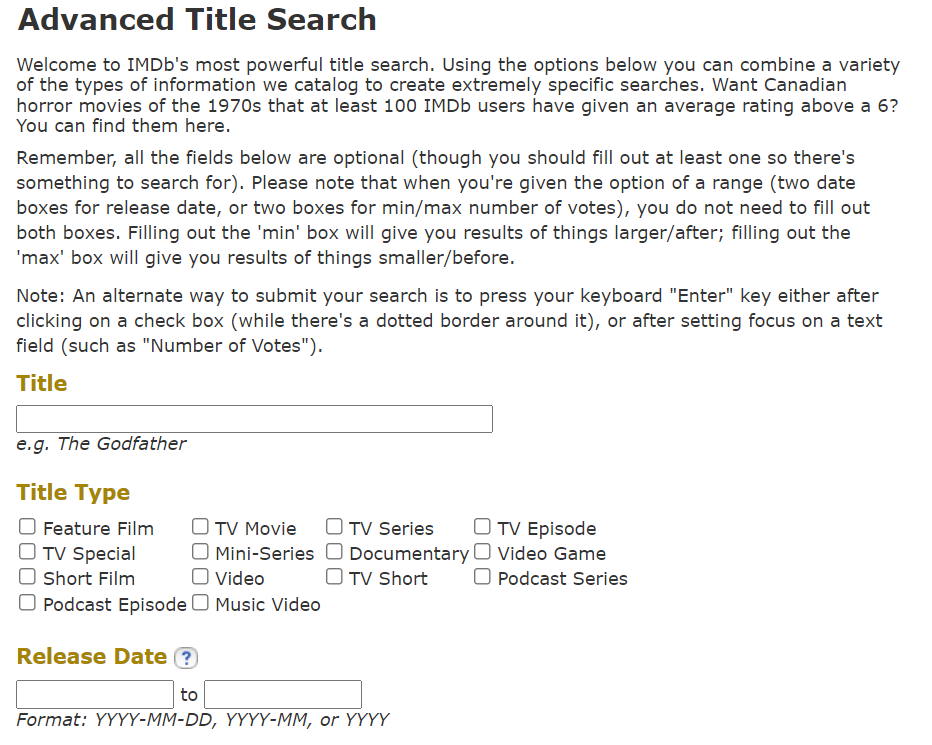
##### 设定范围是：
* 1980-2021年内
* 评论数大于5000
* 时长超过60分钟


In [5]:
# 存放URL的数组
Url_Arr = []

# 共12000多条数据，每页250条，所以这里设定页数为480页
MAX_PAGE = 480

# 生成所有URL
for i in range(0,MAX_PAGE):
    totalRecords = 0 if i==0 else (250*i)+1
    imdb_url = f'https://www.imdb.com/search/title/?title_type=feature&release_date=1980-01-01,2021-12-31&num_votes=5000,&runtime=60,&count=250&start={totalRecords}&ref_=adv_nxt'
    Url_Arr.append(imdb_url)

#### 简单查看一下url是否成功生成

In [6]:
Url_Arr[276]

'https://www.imdb.com/search/title/?title_type=feature&release_date=1980-01-01,2021-12-31&num_votes=5000,&runtime=60,&count=250&start=69001&ref_=adv_nxt'

### 设定并发线程数
* 因为需要爬取的数据太多了，所以需要使用Python的并发API使进程无缝并行运行

In [7]:
# 将最大线程设为50
MAX_THREADS = 50

# 并行执行函数
def Scraper(urls):
    threads = min(MAX_THREADS, len(urls))
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        executor.map(main, urls)

### 开始爬取

In [8]:
# 调用爬取程序，并传入所有已生成的URL
Scraper(Url_Arr)

### 将所得数据整理并输出

In [9]:
# 将所有数据整合成DataFrame格式
movieDf = pd.DataFrame({
    "Title": movie_title_arr,
    "Release_Year": movie_year_arr,
    "Certification": movie_certification_arr,
    "Runtime": movie_runtime_arr,
    "Rating": movie_rating_arr,
    "Votes": movie_votes_arr,
    "Genre": movie_genre_arr,
    "Synopsis": movie_synopsis_arr,
    "image_url": image_url_arr,
    "title_id": title_id_arr,
})


#输出成csv文件，如果使用xlsx文件可能会因为数据量过多，超出文件承受范围
movieDf.to_csv('IMDB1980-2021.csv', index=False)
